In [1]:
import argparse
import numpy as np
from environment import MountainCar, GridWorld

python q_learning.py gw tile gw_simple_weight.out gw_simple_returns.out 1 1 0.0 1 1

python q_learning.py gw tile gw_weight.out gw_returns.out 3 5 0.0 0.9 0.01

python q_learning.py mc tile mc_tile_weight.out mc_tile_returns.out 25 200 0.0 0.99 0.005

python q_learning.py mc raw mc_raw_weight.out mc_raw_returns.out 4 200 0.05 0.99 0.01

### Dev Section Start

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('environment', type=str, choices=['mc', 'gw'],help='the environment to use')
parser.add_argument('mode', type=str, choices=['raw', 'tile'],help='mode to run the environment in')
parser.add_argument('weight_out', type=str,help='path to output the weights of the linear model')
parser.add_argument('returns_out', type=str,help='path to output the returns of the agent')
parser.add_argument('episodes', type=int,help='the number of episodes to train the agent for')
parser.add_argument('max_iterations', type=int,help='the maximum of the length of an episode')
parser.add_argument('epsilon', type=float,help='the value of epsilon for epsilon-greedy')
parser.add_argument('gamma', type=float,help='the discount factor gamma')
parser.add_argument('learning_rate', type=float,help='the learning rate alpha')
parser.add_argument('--debug', type=bool, default=True,help='set to True to show logging')
parser.environment = "mc"
parser.mode = "tile"
parser.weight_out = "mc_raw_weight.out"
parser.returns_out = "mc_raw_returns.out"
parser.episodes = 400
parser.max_iterations = 200
parser.epsilon = 0.05
parser.gamma = 0.99
parser.learning_rate = 0.00005
parser.debug = False
args = parser

In [3]:
mode = args.mode
weight_out = args.weight_out
returns_out = args.returns_out
episodes = args.episodes
max_iterations = args.max_iterations
epsilon = args.epsilon
gamma = args.gamma
learning_rate = args.learning_rate
debug = args.debug
if args.environment == 'mc':
    env = MountainCar(mode=mode, debug=debug)
else:
    env = GridWorld(mode=mode, debug=debug)

In [4]:
# TODO: Initialize your weights/bias here
weights = np.zeros((env.state_space,env.action_space),dtype=float) # Our shape is |S| x |A|, if this helps.
bias = 0.0
# If you decide to fold in the bias (hint: don't), recall how the bias is defined!

In [5]:
def create_state_array (state,state_space):
    state_array = np.zeros((state_space,1),dtype=float)
    for s, v in state.items():
        state_array[s,0] = v
    return state_array

In [6]:
def optimal_action(state_array,action_space,weights,bias):
    action = 0
    action_q = state_array.T.dot(weights[:,action])+bias
    for a in range(1,action_space):
        q = state_array.T.dot(weights[:,a])+bias
        if q > action_q:
            action_q = q
            action = a
    return action

In [7]:
def update_weight_bias(state_array,action,learning_rate,gamma,reward,q,q1,weights,bias):
    value = learning_rate*(q-(reward+gamma*q1))
#     print(weights)
#     print(action)
#     print("value:" + str(value))
#     if reward > 0:
#         print(state_array.T)
#         print(value)
#         print(weights)
    weights[:,action] =weights[:,action] - value*state_array.T
#     if reward > 0:
#         print("updated")
#         print(weights)
#     print(weights)
#     print("next")
    return weights, bias-value

In [8]:
returns = []  # This is where you will save the return after each episode
for episode in range(episodes):
    # Reset the environment at the start of each episode
    state = env.reset()  # `state` now is the initial state
    total_reward = 0
    for it in range(max_iterations):
        #Create state array
        state_array = create_state_array(state, env.state_space)
        #Identify optimal action with max q
        exploit_action = optimal_action(state_array,env.action_space,weights,bias)
        if epsilon > 0:
            explore_action =  np.random.randint(low=0, high=env.action_space - 1, size=(1))
            action = int(np.random.choice([exploit_action,explore_action], 1, replace=True, p=[1-epsilon,epsilon])[0])
        else:
            action = exploit_action
        q_value = state_array.T.dot(weights[:,action])+bias
        #step
        state_1, reward, done =  env.step(action)
        total_reward +=reward
        #Idetify q value for state_1
        state_1_array = create_state_array(state_1, env.state_space)
        next_q_value = state_1_array.T.dot(weights[:,optimal_action(state_1_array,env.action_space,weights,bias)])+bias
        #update weight and bias
        weights,bias = update_weight_bias(state_array,action,learning_rate,gamma,reward,q_value,next_q_value,weights,bias)
        if done == True:
            break
        state = state_1.copy()
    returns.append(total_reward)
        # TODO: Fill in what we have to do every iteration
        # Hint 1: `env.step(ACTION)` makes the agent take an action
        #         corresponding to `ACTION` (MUST be an INTEGER)
        # Hint 2: The size of the action space is `env.action_space`, and
        #         the size of the state space is `env.state_space`
        # Hint 3: `ACTION` should be one of 0, 1, ..., env.action_space - 1
        # Hint 4: For Grid World, the action mapping is
        #         {"up": 0, "down": 1, "left": 2, "right": 3}
        #         Remember when you call `env.step()` you have to pass
        #         the INTEGER representing each action!

C:\Users\yingy\AppData\Local\Temp/ipykernel_17556/1023719501.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  action = int(np.random.choice([exploit_action,explore_action], 1, replace=True, p=[1-epsilon,epsilon])[0])


In [9]:
import pandas as pd
rm = []
window_size = 25
windows = pd.Series(returns).rolling(window_size)
moving_averages = windows.mean()
moving_averages_list = moving_averages.tolist()

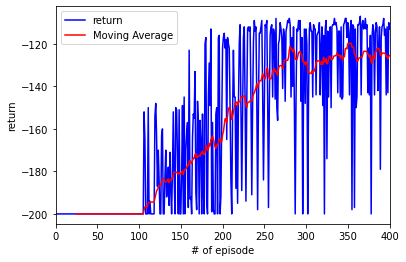

In [10]:
import matplotlib.pyplot as plt
x = list(range(1,401))
plt.plot(x, returns,'b',label="return")
plt.plot(x, moving_averages_list,'r',label="Moving Average")
# plt.ylim(0, 0.6)
plt.xlim(0,401)
plt.legend(loc="upper left")
plt.xlabel("# of episode")
plt.ylabel("return")
plt.savefig('1_Tile.png')
plt.show()

In [ ]:
for x in np.ravel(weights):
    print(x) 

In [ ]:
def output(weights,bias,returns,weight_out,returns_out):
    with open (returns_out, "w") as f_r:
        for r in returns:
            f_r.write(str(r)+"\n")
    with open(weight_out,"w") as f_w:
        f_w.write(str(bias[0])+"\n")
        for x in np.ravel(weights): 
            f_w.write(str(x)+"\n")

In [ ]:
output(weights,bias,returns,weight_out,returns_out)

### Dev Section End

In [ ]:
def main(args):
    # Command line inputs
    mode = args.mode
    weight_out = args.weight_out
    returns_out = args.returns_out
    episodes = args.episodes
    max_iterations = args.max_iterations
    epsilon = args.epsilon
    gamma = args.gamma
    learning_rate = args.learning_rate
    debug = args.debug

    # We will initialize the environment for you:
    if args.environment == 'mc':
        env = MountainCar(mode=mode, debug=debug)
    else:
        env = GridWorld(mode=mode, debug=debug)

    # TODO: Initialize your weights/bias here
    # weights = ...  # Our shape is |A| x |S|, if this helps.
    # bias = ...
    # If you decide to fold in the bias (hint: don't), recall how the bias is
    # defined!

    returns = []  # This is where you will save the return after each episode
    for episode in range(episodes):
        # Reset the environment at the start of each episode
        state = env.reset()  # `state` now is the initial state
        for it in range(max_iterations):
            # TODO: Fill in what we have to do every iteration
            # Hint 1: `env.step(ACTION)` makes the agent take an action
            #         corresponding to `ACTION` (MUST be an INTEGER)
            # Hint 2: The size of the action space is `env.action_space`, and
            #         the size of the state space is `env.state_space`
            # Hint 3: `ACTION` should be one of 0, 1, ..., env.action_space - 1
            # Hint 4: For Grid World, the action mapping is
            #         {"up": 0, "down": 1, "left": 2, "right": 3}
            #         Remember when you call `env.step()` you have to pass
            #         the INTEGER representing each action!
            pass  # You can delete this `pass`

    # TODO: Save output files

In [ ]:
if __name__ == "__main__":
    # No need to change anything here
    parser = argparse.ArgumentParser()
    parser.add_argument('environment', type=str, choices=['mc', 'gw'],
                        help='the environment to use')
    parser.add_argument('mode', type=str, choices=['raw', 'tile'],
                        help='mode to run the environment in')
    parser.add_argument('weight_out', type=str,
                        help='path to output the weights of the linear model')
    parser.add_argument('returns_out', type=str,
                        help='path to output the returns of the agent')
    parser.add_argument('episodes', type=int,
                        help='the number of episodes to train the agent for')
    parser.add_argument('max_iterations', type=int,
                        help='the maximum of the length of an episode')
    parser.add_argument('epsilon', type=float,
                        help='the value of epsilon for epsilon-greedy')
    parser.add_argument('gamma', type=float,
                        help='the discount factor gamma')
    parser.add_argument('learning_rate', type=float,
                        help='the learning rate alpha')
    parser.add_argument('--debug', type=bool, default=False,
                        help='set to True to show logging')
    main(parser.parse_args())